<a href="https://colab.research.google.com/github/StuartLiv/CPSC-440-Project/blob/main/models/ssimloss/eighth_size_256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array # TODO don't use keras
from keras.utils import load_img
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import random

from google.colab import userdata

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [2]:
!pip install pytorch-msssim -q
from pytorch_msssim import ms_ssim

In [3]:

!git clone https://{userdata.get('token')}@github.com/StuartLiv/CPSC-440-Project
%pwd

Cloning into 'CPSC-440-Project'...
remote: Enumerating objects: 166369, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 166369 (delta 53), reused 38 (delta 15), pack-reused 166262
Receiving objects: 100% (166369/166369), 785.84 MiB | 42.71 MiB/s, done.
Resolving deltas: 100% (36931/36931), done.
Updating files: 100% (249466/249466), done.


'/content'

In [4]:
!git config --global user.email {userdata.get('email')}
!git config --global user.name {userdata.get('name')}

# 2. Preprocess data

Datasets:
- `medset_multisize`
  - Single datasets. Dataset construction code in repo too
  - 12000 Images, in randomized order
  - Res 256x256 (grayscale images also available in 128x128, 64x64, 32x32)


In [5]:
''' Returns an array containing all images in folder, sorted by filename. Useful for color/gray/downsize versions in different folders with same filename.
@param path - directory with images
@return
'''
def make_image_arr(path):

  def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

  files = os.listdir(path)
  files = sorted_alphanumeric(files)

  arr = []
  for i in tqdm(files):
    img = load_img(path + '/'+i)
    arr.append(img_to_array(img) / 255)

  return np.array(arr)


Load datasets, partition sets, and make tensors in color-layer order for convolutions



In [6]:
training_proportion = 0.8
validation_proportion = 0.0

def load_and_partition(path):
  arr = make_image_arr(path)
  cutoff = int(len(arr)*training_proportion)
  return arr[:cutoff], arr[cutoff:]

def make_tensor(arr):
  #Axis transformation: Shape (n, h, w, 3) -> (n, 3, h, w)
  #Inversion is np.moveaxis(arr, [2,2], [1,1])
  return torch.from_numpy(np.moveaxis(arr, [3,1], [1,2]))


#Extract single channel, since all 3 are the same in gray images
def make_gray_tensor(arr):
  return make_tensor(arr)[:, 0:1, :, :]

color_train, color_test = load_and_partition('/content/CPSC-440-Project/datasets/medset_multisize/color')
gray_train, gray_test = load_and_partition('/content/CPSC-440-Project/datasets/medset_multisize/gray32')

assert(len(color_train) == len(gray_train) and len(color_test) == len(gray_test))
n_train = len(color_train)
n_test = len(color_test)

color_train_tensors = make_tensor(color_train)
color_test_tensors = make_tensor(color_test)

gray_train_tensors = make_gray_tensor(gray_train)
gray_test_tensors = make_gray_tensor(gray_test)

100%|██████████| 12000/12000 [00:01<00:00, 6099.56it/s]


# 3. Model
Model generated below:

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 3, 3, padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the autoencoder
autoencoder = Autoencoder()

Load stored decoder from full size model training, and fix decoder parameters.

In [8]:
autoencoder.decoder = torch.load('/content/CPSC-440-Project/models/ssimloss/decoder_weights_256_4epochnegssim')
for param in autoencoder.decoder.parameters():
  param.requires_grad = False

(optionally) load pre-trained encoder

In [ ]:
autoencoder.encoder = torch.load('/content/CPSC-440-Project/models/32_dim_encoder_weights')

Train Model (SGD)

In [9]:
def ms_ssimloss(input, target):
  return -ms_ssim(input, target)
criterion = ms_ssimloss
optimizer = optim.Adam(autoencoder.encoder.parameters(), lr=0.001)
autoencoder.train()
autoencoder.to(device)

# Training loop
num_epochs = 5
num_iterations = 1000
batch_size=32
for epoch in range(num_epochs):
  for iteration in range(num_iterations):
      running_loss = 0.0
      batch_indexes = torch.randint(high=n_train, size=(batch_size,1))

      inputs = gray_train_tensors[batch_indexes].squeeze(1).to(device)
      targets = color_train_tensors[batch_indexes].squeeze(1).to(device)

      outputs = autoencoder(inputs)
      loss = criterion(outputs, targets)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
  print('[%d] loss: %.5f' % (epoch+1, running_loss / batch_size))

print('Finished Training')

[1] loss: -0.03125
[2] loss: -0.03125


KeyboardInterrupt: 

Simple Image Space Exploration

i: 1646
LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT
tensor(0.0179, grad_fn=<MseLossBackward0>)


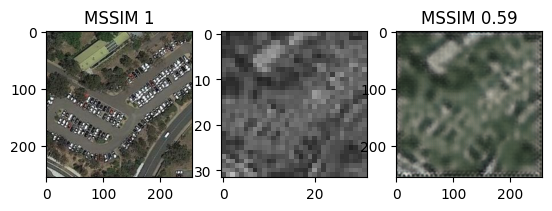

i: 189
LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT
tensor(0.0070, grad_fn=<MseLossBackward0>)


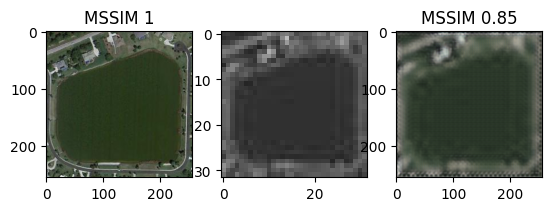

i: 1284
LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT
tensor(0.0096, grad_fn=<MseLossBackward0>)


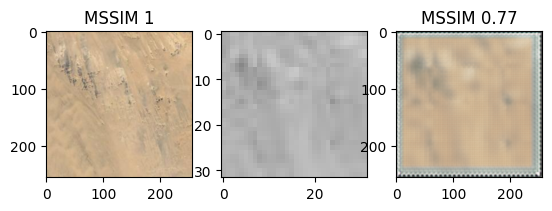

In [13]:
autoencoder.eval()
for i in np.random.randint(n_test,size=3):
  image_bw = gray_test[i]
  image_c = color_test[i]

  # Colorize the image
  t = gray_test_tensors[i].unsqueeze(0).to(device)
  colorized_image = autoencoder(t)
  colorized_image_format = np.moveaxis(colorized_image.squeeze().cpu().detach().numpy(), [1,2], [0,1])

  print("i:", i)
  print("LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT")
  print(nn.MSELoss()(colorized_image.cpu(), color_test_tensors[i]))

  plt.subplot(1,3,1)
  plt.imshow(image_c)
  plt.title(f"MSSIM 1")

  plt.subplot(1,3,2)
  plt.imshow(image_bw)
  # input_mssim = ms_ssim(color_test_tensors[i].unsqueeze(0).to(device), gray_test_tensors[i].repeat(3,1,1).unsqueeze(0).to(device), data_range=1, size_average=True) # return scalar
  # plt.title(f"MSSIM {input_mssim:.2f}")

  plt.subplot(1,3,3)
  plt.imshow(colorized_image_format)
  output_mssim = ms_ssim(color_test_tensors[i].unsqueeze(0).to(device), colorized_image.to(device), data_range=1, size_average=True) # return scalar
  plt.title(f"MSSIM {output_mssim:.2f}")

  plt.show()

Save current model

In [14]:
torch.save(autoencoder.encoder,'/content/CPSC-440-Project/models/ssimloss/32_dim_encoder_weights')

# 4. Push changes

Look for any changes in the project directory, excluding this notebook, and push them.


In [15]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [18]:
!git add .

In [17]:
%cd CPSC-440-Project/
!git status

/content/CPSC-440-Project
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   models/ssimloss/32_dim_encoder_weights

no changes added to commit (use "git add" and/or "git commit -a")


In [19]:
!git commit -m "32x32 size model weights (2 epochs with neg msssim loss)"

[main c55277d9f] 32x32 size model weights (2 epochs with neg msssim loss)
 1 file changed, 0 insertions(+), 0 deletions(-)
 rewrite models/ssimloss/32_dim_encoder_weights (83%)


In [20]:
!git push

Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 16 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 15.46 KiB | 15.46 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/StuartLiv/CPSC-440-Project
   8a18a679e..c55277d9f  main -> main


# 4. Save notebook

Commiting this notebook requires a special maneuver:

> File > Save a copy in github > enter original `path` + new commit msg

That's it!